In [35]:
import warnings
warnings.filterwarnings('ignore')


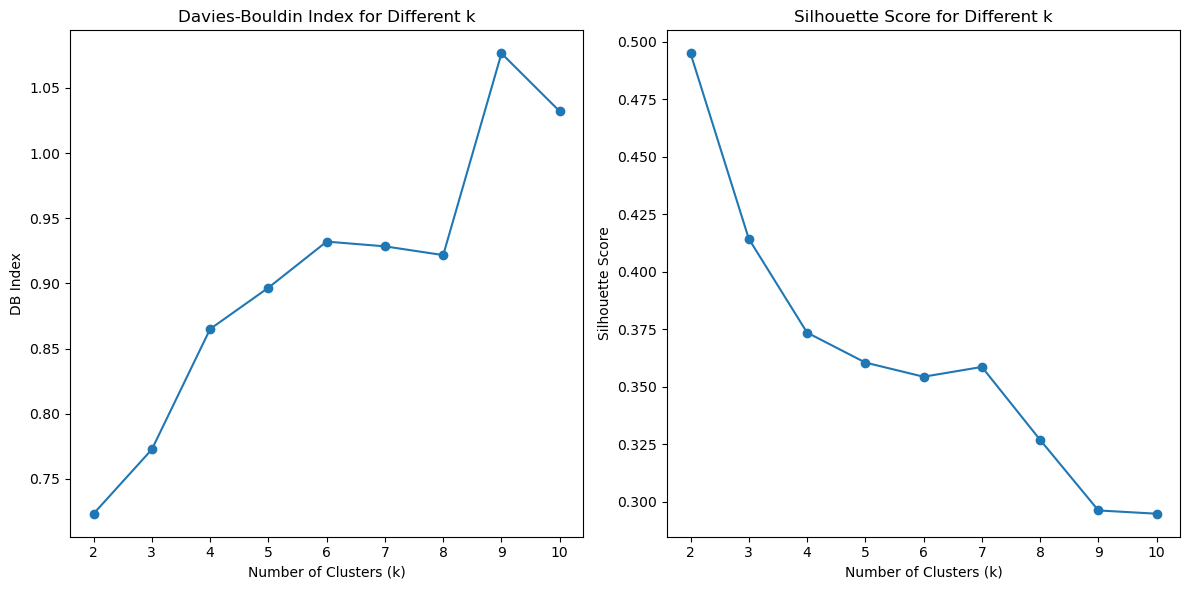

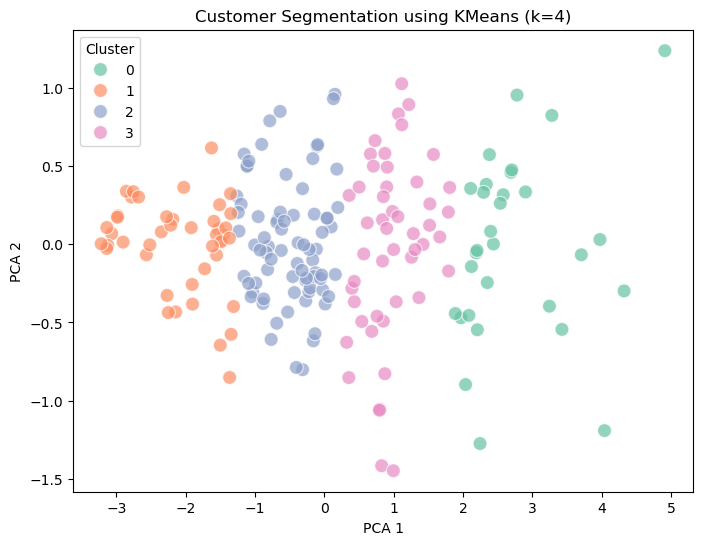

Final Davies-Bouldin Index for k=4: 0.8650620583623065
Number of clusters formed: 4
Davies-Bouldin Index: 0.8650620583623065
Cluster Summary:
   Cluster  avg_total_value  avg_quantity  avg_transaction_date
0        0      6263.447333     23.000000              8.433333
1        1      1273.368182      5.272727              2.363636
2        2      2982.406711     10.868421              4.394737
3        3      4477.572041     16.102041              6.306122


In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customer and transaction data
customer_transactions = pd.merge(transactions, customers, on="CustomerID")

# Create additional features (e.g., total transaction value per customer)
customer_summary = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',               # Total value spent by the customer
    'Quantity': 'sum',                 # Total number of products bought
    'TransactionDate': 'nunique',      # Number of unique transaction dates per customer
}).reset_index()

# Add customer demographic information (Region)
customer_summary = pd.merge(customer_summary, customers[['CustomerID', 'Region']], on="CustomerID")

# Feature Engineering - Standardizing the data for clustering
features = customer_summary[['TotalValue', 'Quantity', 'TransactionDate']]  # Selecting key features

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering with a range of cluster numbers (between 2 and 10)
db_index_values = []  # To store Davies-Bouldin Index for different k
silhouette_scores = []  # To store silhouette scores for different k

# Test for a range of clusters
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    
    # Calculate the Davies-Bouldin Index for the clustering
    db_index_values.append(davies_bouldin_score(scaled_features, kmeans.labels_))
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plotting the Davies-Bouldin Index and Silhouette Score for different k values
plt.figure(figsize=(12, 6))

# Davies-Bouldin Index plot
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_index_values, marker='o', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')

# Silhouette Score plot
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Based on DBI and silhouette score, choose the best k (Here, assuming k=4 based on the plot)
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(scaled_features)

# Reduce the data to 2D using PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_summary['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=pca_df, s=100, alpha=0.7)
plt.title(f'Customer Segmentation using KMeans (k={best_k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

# Calculate the final Davies-Bouldin Index for the chosen number of clusters
db_index_final = davies_bouldin_score(scaled_features, customer_summary['Cluster'])
print(f'Final Davies-Bouldin Index for k={best_k}: {db_index_final}')

# Report Clustering Results
num_clusters = customer_summary['Cluster'].nunique()
print(f'Number of clusters formed: {num_clusters}')
print(f'Davies-Bouldin Index: {db_index_final}')

# Cluster Summary: Average values for each cluster
cluster_summary = customer_summary.groupby('Cluster').agg(
    avg_total_value=('TotalValue', 'mean'),
    avg_quantity=('Quantity', 'mean'),
    avg_transaction_date=('TransactionDate', 'mean')
).reset_index()

print("Cluster Summary:")
print(cluster_summary)
